This notebook is a part of a bachelor's thesis written by Asger Song Høøck Poulsen.

This notebook performs Singular Value Decomposition on Attention Matrices of BART-base (and BART-large) and replaces original weight matrices by their low-rank Approximation.
The goal of this notebook is to assess the effectiveness of low-rank approximation BART for summarization.

# Dependencies

In [ ]:
!nvidia-smi

Fri Jun  7 21:44:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   58C    P8              14W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install rouge
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git
# install additional dependencies needed for training
! pip install datasets transformers rouge-score nltk py7zr tensorboard

# for evaluation
!pip install evaluate
!pip install nltk

!pip install tensorflow==2.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 75.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to 

In [ ]:
from torch import nn
from dataclasses import dataclass
from torch.nn import functional as F
import copy
import torch
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import DataCollatorForSeq2Seq
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer

In [ ]:
!pip install datasets transformers rouge-score nltk py7zr accelerate

In [ ]:
model_checkpoint = "facebook/bart-base"

## Loading the dataset

In [ ]:
from datasets import load_dataset, load_metric

raw_datasets = load_dataset("samsum")
metric = load_metric("rouge")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning: The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

<ipython-input-6-a2ef1525156b>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
raw_datasets["test"]

Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 819
})

## Preprocessing the data

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
max_input_length = 512
max_target_length = 128

def preprocess_function(examples):
    inputs = [doc for doc in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3963: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
len(tokenized_datasets)

3

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

## Fine-tuning the model

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
batch_size = 4
args = Seq2SeqTrainingArguments(
    "test-dialogue-summarization",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import accelerate

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,1.815700,1.543361,47.514900,24.586800,40.399100,43.972500,18.091700
2,1.458700,1.489950,48.360500,25.598600,41.272800,44.942500,17.880200
4,1.266000,1.495493,48.338000,25.252300,41.116400,44.727300,18.094100
6,1.123200,1.523768,48.887200,25.618700,41.335700,45.155400,18.206600
8,1.041000,1.528558,49.063600,25.955900,41.537300,45.311800,18.343500
9,1.019900,1.539690,48.923000,25.675400,41.485100,45.143400,18.327600


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

TrainOutput(global_step=18410, training_loss=1.2973535325331638, metrics={'train_runtime': 4518.6238, 'train_samples_per_second': 32.603, 'train_steps_per_second': 4.074, 'total_flos': 2.448145469952e+16, 'train_loss': 1.2973535325331638, 'epoch': 9.997284822155851})

In [ ]:
trainer.evaluate()

{'eval_loss': 1.539689540863037,
 'eval_rouge1': 48.923,
 'eval_rouge2': 25.6754,
 'eval_rougeL': 41.4851,
 'eval_rougeLsum': 45.1434,
 'eval_gen_len': 18.3276,
 'eval_runtime': 66.0149,
 'eval_samples_per_second': 12.391,
 'eval_steps_per_second': 3.105,
 'epoch': 9.997284822155851}

In [ ]:
import torch

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize input
formatted_query = "Summarize: " + raw_datasets["test"][0]["dialogue"]
tokenized_text = tokenizer(formatted_query, truncation=True, max_length=2048, return_tensors='pt')

# Move tokenized text to the same device as the model
tokenized_text = tokenized_text.to(device)

# Generate predictions
generated_ids = model.generate(
    **tokenized_text,
    max_new_tokens=150,
    num_beams=4,
    no_repeat_ngram_size=2,
    early_stopping=True
)
prediction = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [ ]:
prediction

"Hannah is looking for Betty's number. Amanda can't find it. Larry called her last time they were at the park together."

# LoRA

In [ ]:
from torch import nn
from dataclasses import dataclass
from torch.nn import functional as F

@dataclass
class LowRankConfig:
    rank:int
    target_modules: list[str]

class LowRankLayer(nn.Module):
    """given a linear layer find low rank decomposition"""
    def __init__(self, rank, full_rank_layer):
        super().__init__()
        self.rank = rank
        self.bias = full_rank_layer.bias
        U, S, Vh = torch.linalg.svd(full_rank_layer.weight, driver = 'gesvd')
        S_diag = torch.diag(S)
        self.U = U[:, :self.rank]
        self.S = S_diag[:self.rank, :self.rank]
        self.Vh = Vh[:self.rank, :]
        self.weight = full_rank_layer.weight

    """forward pass through the low-rank layer"""
    def forward(self, x):
        output_t1 = F.linear(x, self.Vh)
        output_t2 = F.linear(output_t1, self.S)
        output = F.linear(output_t2, self.U, self.bias)

        return output

# find the module that ends target suffix
def get_submodules(model, key):
    parent = model.get_submodule(".".join(key.split(".")[:-1]))
    target_name = key.split(".")[-1]
    target = model.get_submodule(key)
    return parent, target, target_name

# this function replaces a target layer with low rank layer
def recursive_setattr(obj, attr, value):
    attr = attr.split('.', 1)
    if len(attr) == 1:
        setattr(obj, attr[0], value)
    else:
        recursive_setattr(getattr(obj, attr[0]), attr[1], value)

# Traversing and modifying the BART model
def loRA_Transform(model, config):
  for key, module in model.named_modules():
      target_module_found = any(key.endswith("." + target_key) for target_key in config.target_modules)
      if target_module_found:
          low_rank_layer = LowRankLayer(config.rank, module)
          #replace target layer with low rank layer
          recursive_setattr(model, key, low_rank_layer)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create a low-rank replica of original model (model-bart-base)

In [ ]:
import copy
# Create a copy of the original model for LoRA (with full-rank version)
model_bart_lr_full = copy.deepcopy(model)

In [ ]:
# full rank decomposition of SelfAttention Value and Output Matrices
out_config = LowRankConfig(
    rank= 768,
    target_modules=["out_proj"]
)

loRA_Transform(model_bart_lr_full, out_config)

In [ ]:
# full rank decomposition of SelfAttention Value and Output Matrices
v_config = LowRankConfig(
    rank= 767,
    target_modules=["v_proj"]
)

loRA_Transform(model_bart_lr_full, v_config)

In [ ]:
#low rank decomposition of SelfAttention Key and Query Matrices
config = LowRankConfig(
    rank= 766,
    target_modules=["k_proj", "q_proj"]
)

loRA_Transform(model_bart_lr_full, config)

# Comparing model_bart_base with model_bart_lr_full
This section compares the original BART model with its corresponding low-rank replica

In [ ]:
trainer_full = Seq2SeqTrainer(
    model=model_bart_lr_full,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


trainer_full.evaluate()

{'eval_loss': 1.4849486351013184,
 'eval_rouge1': 47.9293,
 'eval_rouge2': 24.947,
 'eval_rougeL': 40.7413,
 'eval_rougeLsum': 44.3721,
 'eval_gen_len': 18.165,
 'eval_runtime': 83.4557,
 'eval_samples_per_second': 9.802,
 'eval_steps_per_second': 2.456}

In [ ]:
# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bart_lr_full.to(device)

# Tokenize input
formatted_query = "Summarize: " + raw_datasets["test"][0]["dialogue"]
tokenized_text = tokenizer(formatted_query, truncation=True, max_length=2048, return_tensors='pt')

# Move tokenized text to the same device as the model
tokenized_text = tokenized_text.to(device)

# Generate predictions
generated_ids = model_bart_lr_full.generate(
    **tokenized_text,
    max_new_tokens=150,
    num_beams=4,

    no_repeat_ngram_size=2,
    early_stopping=True
)
prediction = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [ ]:
prediction

"Hannah doesn't know Betty's number. She texted Larry last time they were at the park together."

# Predictions

## Evaluate one summary

In [ ]:
import gc
import torch

# Initialize storage for metrics and predictions
metrics_keys = ['eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum', 'eval_gen_len', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second']
metrics = {key: [] for key in metrics_keys}
predictions = []

# Define the range of ranks
start_rank = 765
end_rank = 150
step_size = 5

torch.cuda.empty_cache()  # Clear any residual GPU memory

for rank in range(start_rank, end_rank - 1, -step_size):
    gc.collect()  # Garbage collect Python objects
    torch.cuda.empty_cache()  # Clear CUDA cache

    # Perform the copy and transformation on GPU
    compressed_model = copy.deepcopy(model).to(device)
    config = LowRankConfig(rank=rank, target_modules=["out_proj", "q_proj", "v_proj", "k_proj"])
    loRA_Transform(compressed_model, config)

    # Define a trainer for evaluation
    trainer = Seq2SeqTrainer(
        model=compressed_model,
        args=args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=[tokenized_datasets["test"][0]],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Perform evaluation
    eval_results = trainer.evaluate()

    # Store metrics and predictions
    for key in metrics_keys:
        if key in eval_results:
            metrics[key].append(eval_results[key])
        else:
            metrics[key].append(None)  # Append None if the key doesn't exist in results

    # Generate and store predictions for the first test sample, handling the device movement if needed
    if compressed_model.device.type == 'cuda':
      # Move tokenized text to the same device as the model
      tokenized_text = tokenized_text.to(device)

    # Generate predictions
    generated_ids = compressed_model.generate(
        **tokenized_text,
        max_new_tokens=150,
        num_beams=4,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    prediction = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    predictions.append(prediction)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1244: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


### Print and plot

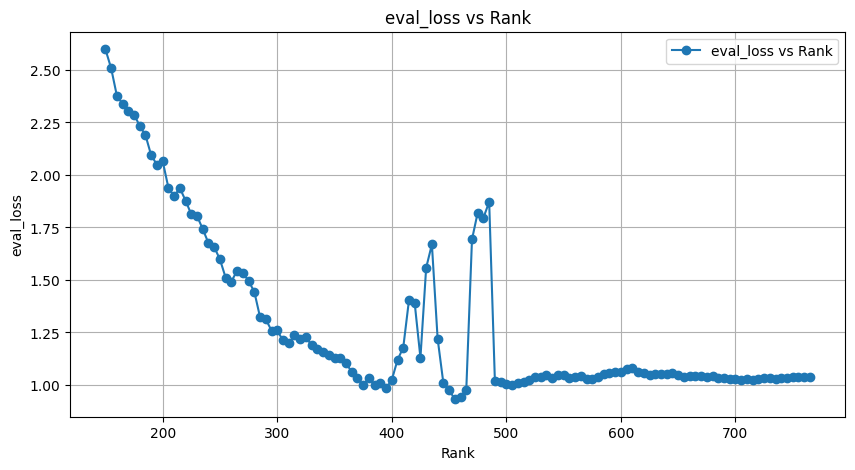

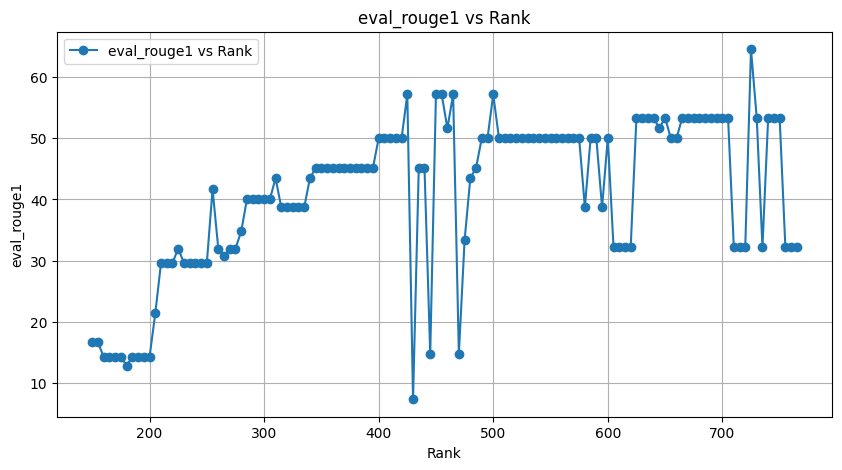

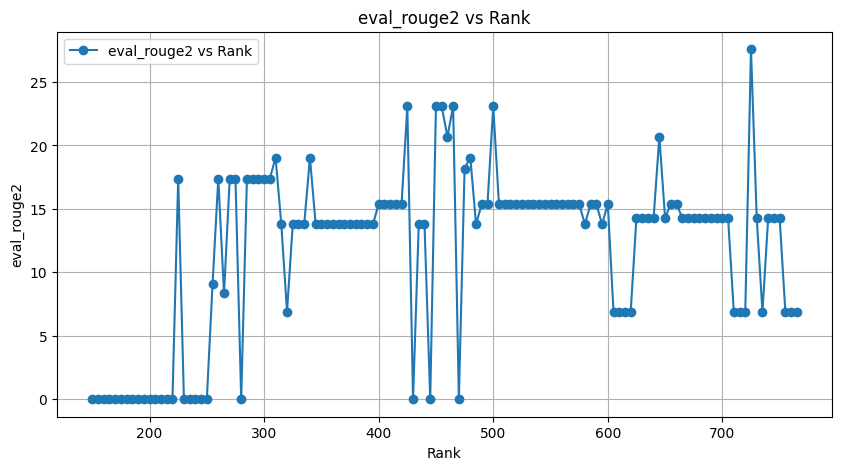

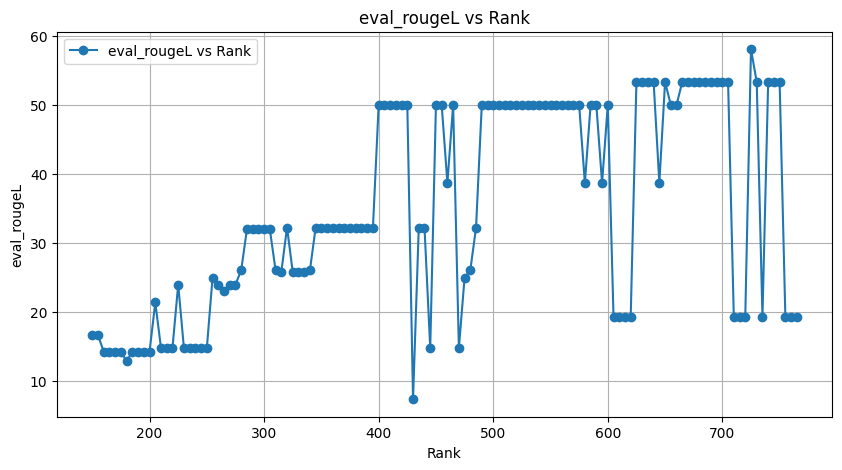

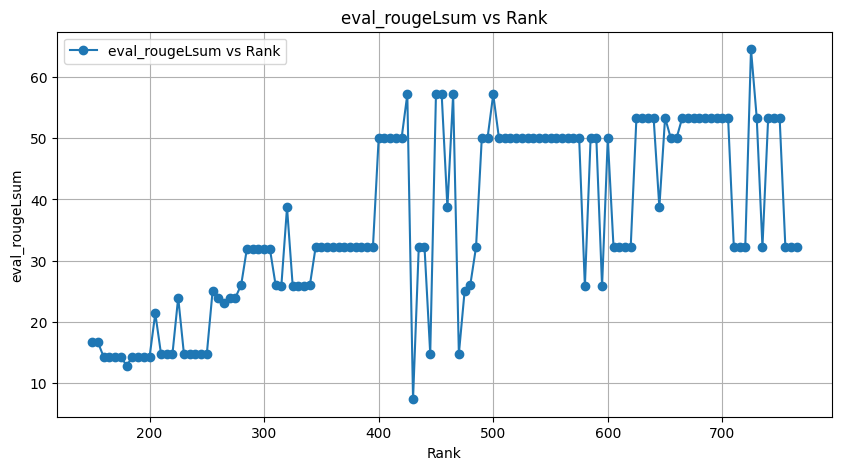

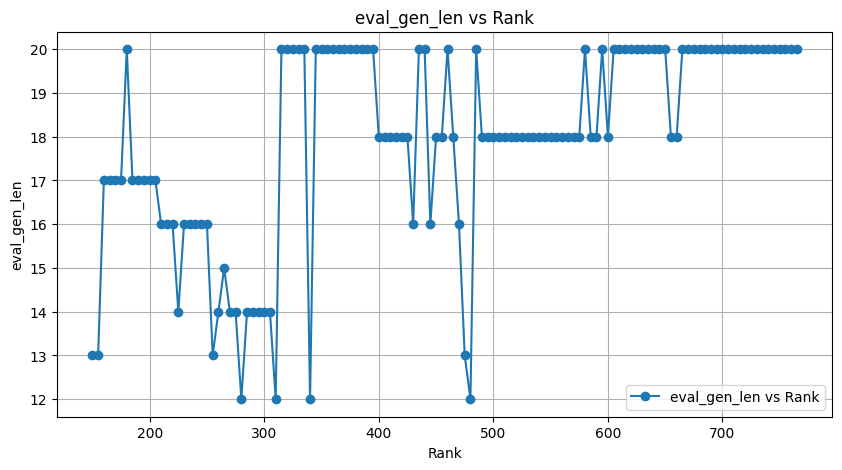

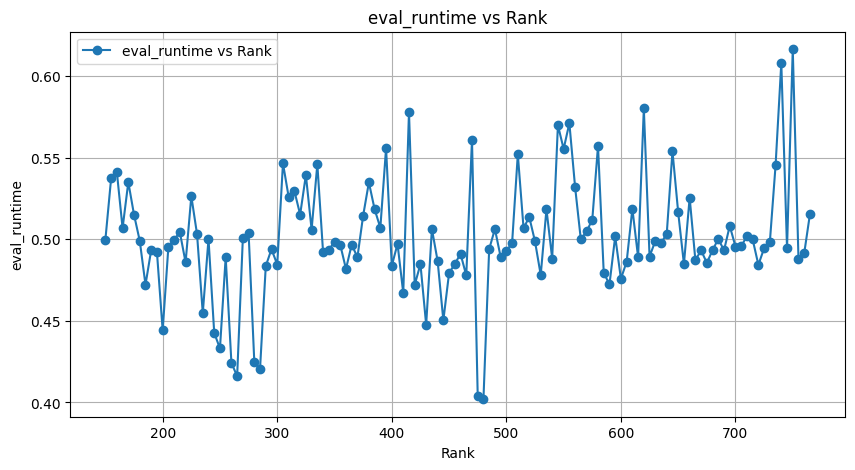

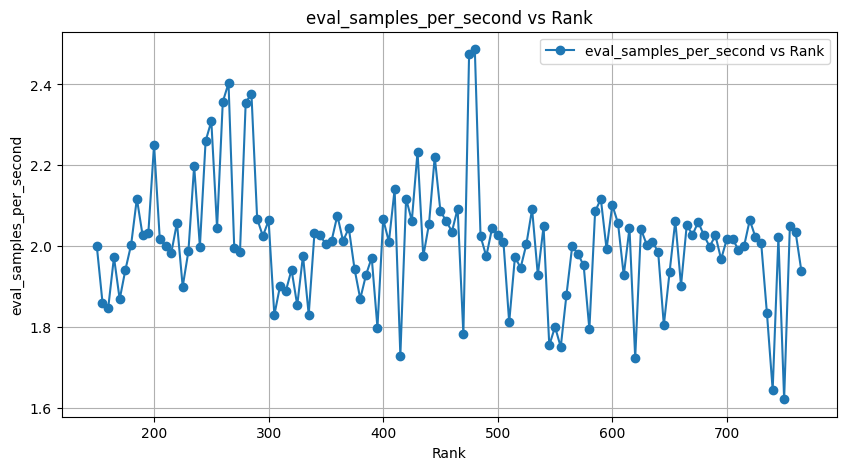

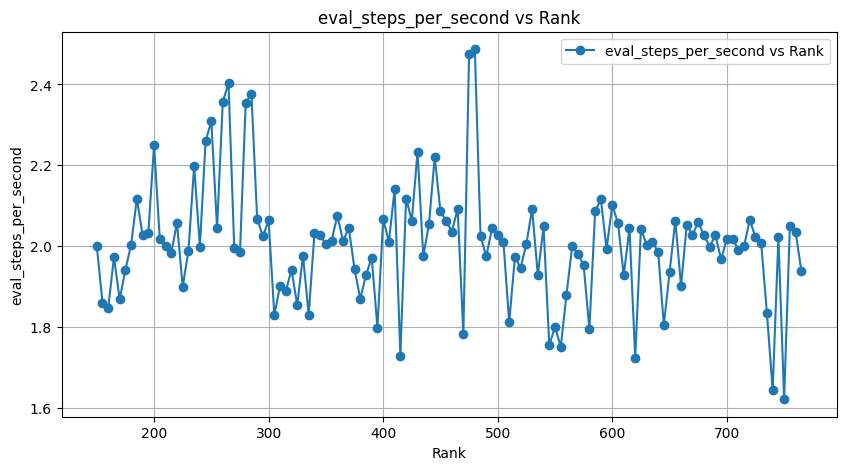

In [ ]:
import matplotlib.pyplot as plt

ranks = list(range(765, 150 - 1, -5))

# Plot each metric in a separate figure
for key in metrics_keys:
    plt.figure(figsize=(10, 5))
    plt.plot(ranks, metrics[key], marker='o', linestyle='-', label=f'{key} vs Rank')
    plt.title(f'{key} vs Rank')
    plt.xlabel('Rank')
    plt.ylabel(key)
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
for rank, pred in zip(ranks, predictions):
    print(f'Rank {rank}: {pred}\n')

Rank 765: Hannah doesn't know Betty's number. She texted Larry last time they were at the park together.

Rank 760: Hannah doesn't know Betty's number. She texted Larry last time they were at the park together.

Rank 755: Hannah doesn't know Betty's number. She texted Larry last time they were at the park together.

Rank 750: Hannah doesn't know Betty's number. She texted Larry last time they were at the park together.

Rank 745: Hannah doesn't know Betty's number. She texted Larry last time they were at the park together.

Rank 740: Hannah doesn't know Betty's number. She texted Larry last time they were at the park together.

Rank 735: Hannah doesn't know Betty's number. She texted Larry last time they were at the park together.

Rank 730: Hannah doesn't know Betty's number. She texted Larry last time they were at the park together.

Rank 725: Hannah doesn't know Betty's number. She texted Larry last time they were at the park together.

Rank 720: Hannah doesn't know Betty's number. 

## Test on whole dataset (evert 50 or 100 rank)

In [ ]:
# Initialize storage for metrics and predictions
base_metrics_keys = ['eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum', 'eval_gen_len', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second']
base_metrics = {key: [] for key in base_metrics_keys}
base_predictions = []

base_model = copy.deepcopy(model).to(device)

# Move the model to GPU if available for evaluation
if torch.cuda.is_available():
    base_model.to('cuda')
"""
Evaluate baseline BART-base and save metrics
"""
# Define a trainer for evaluation
trainer = Seq2SeqTrainer(
    model=base_model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Perform evaluation
eval_results = trainer.evaluate()
print(eval_results)

# Store metrics for the new experiment
for key in base_metrics_keys:
  if key in eval_results:
      base_metrics[key].append(eval_results[key])
  else:
      base_metrics[key].append(None)  # Append None if the key doesn't exist in results

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1244: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'eval_loss': 1.5191065073013306, 'eval_rouge1': 46.6583, 'eval_rouge2': 23.5581, 'eval_rougeL': 39.6272, 'eval_rougeLsum': 42.9047, 'eval_gen_len': 18.1038, 'eval_runtime': 67.906, 'eval_samples_per_second': 12.061, 'eval_steps_per_second': 3.019}


In [ ]:
# Initialize storage for metrics and predictions for the new experiment
new_metrics_keys = ['eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum', 'eval_gen_len', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second']
new_metrics = {key: [] for key in new_metrics_keys}
new_predictions = []

"""
Evaluate compressed BART and save metrics
"""

# Define the range of ranks for the new experiment
start_rank = 765
end_rank = 165
step_size = 10  # Step size is 10 for the new experiment

torch.cuda.empty_cache()  # Clear any residual GPU memory

for rank in range(start_rank, end_rank - 1, -step_size):
    gc.collect()  # Garbage collect Python objects
    torch.cuda.empty_cache()  # Clear CUDA cache

    compressed_model = copy.deepcopy(model).to(device)
    config = LowRankConfig(rank=rank, target_modules=["out_proj", "q_proj", "v_proj", "k_proj"])
    loRA_Transform(compressed_model, config)

    # Move the model to GPU if available for evaluation
    if torch.cuda.is_available():
        compressed_model.to('cuda')

     # Define a trainer for evaluation
    trainer = Seq2SeqTrainer(
        model=compressed_model,
        args=args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Perform evaluation
    eval_results = trainer.evaluate()

    # Store metrics for the new experiment
    for key in new_metrics_keys:
        if key in eval_results:
            new_metrics[key].append(eval_results[key])
        else:
            new_metrics[key].append(None)  # Append None if the key doesn't exist in results


In [ ]:
import matplotlib.pyplot as plt

ranks = list(range(765, 165 - 1, -50))

# Plot each metric in a separate figure
for key in new_metrics_keys:
    plt.figure(figsize=(10, 5))

    # Check if baseline data is available and add it as a single point
    if key in base_metrics and base_metrics[key]:
        # Assuming there's only one entry in base_metrics[key], you can use base_metrics[key][0]
        plt.scatter(768, base_metrics[key], color='red', label='Baseline BART')

    # Plot compressed data
    plt.plot(ranks, new_metrics[key], marker='o', linestyle='-', label='Compressed BART')
    plt.title(f'{key} vs Rank')
    plt.xlabel('Rank')
    plt.ylabel(key)
    plt.grid(True)
    plt.legend()
    plt.show()

# Poster

## Try running on CPU

In [ ]:
class LowRankLayer(nn.Module):
    def __init__(self, rank, full_rank_layer):
        super().__init__()
        self.rank = rank
        self.bias = full_rank_layer.bias.detach()
        U, S, Vh = torch.linalg.svd(full_rank_layer.weight.detach(), full_matrices=False)
        self.U = U[:, :rank].to(full_rank_layer.weight.device)
        self.S = torch.diag(S[:rank]).to(full_rank_layer.weight.device)
        self.Vh = Vh[:rank, :].to(full_rank_layer.weight.device)

    def forward(self, x):
        device = x.device  # Get the device from input tensor
        output_t1 = F.linear(x, self.Vh.to(device))
        output_t2 = F.linear(output_t1, self.S.to(device))
        output = F.linear(output_t2, self.U.to(device), self.bias.to(device))
        return output

In [ ]:
raw_datasets["test"][0]["dialogue"]

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [ ]:
# Tokenize input
formatted_query = "Summarize: " + raw_datasets["test"][0]["dialogue"]
tokenized_text = tokenizer(formatted_query, truncation=True, max_length=2048, return_tensors='pt')

In [ ]:
import gc
import torch

# Initialize storage for metrics and predictions
metrics_keys = ['eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum', 'eval_gen_len', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second']
metrics = {key: [] for key in metrics_keys}
predictions = []

# Define the range of ranks
start_rank = 765
end_rank = 150
step_size = 5

# Before starting the loop, ensure the model is on CPU to free up GPU memory
model.to('cpu')
torch.cuda.empty_cache()  # Clear any residual GPU memory

for rank in range(start_rank, end_rank - 1, -step_size):
    gc.collect()  # Garbage collect Python objects
    torch.cuda.empty_cache()  # Clear CUDA cache

    # Perform the copy and transformation on CPU
    compressed_model = copy.deepcopy(model).to('cpu')
    config = LowRankConfig(rank=rank, target_modules=["out_proj", "q_proj", "v_proj", "k_proj"])
    loRA_Transform(compressed_model, config)

    # Define a trainer for evaluation
    trainer = Seq2SeqTrainer(
        model=compressed_model,
        args=args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=[tokenized_datasets["test"][0]],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Perform evaluation
    eval_results = trainer.evaluate()

    # Store metrics and predictions
    for key in metrics_keys:
        if key in eval_results:
            metrics[key].append(eval_results[key])
        else:
            metrics[key].append(None)  # Append None if the key doesn't exist in results

    # Generate and store predictions for the first test sample, handling the device movement if needed
    if compressed_model.device.type == 'cuda':
      # Move tokenized text to the same device as the model
      tokenized_text = tokenized_text.to(device)

    # Generate predictions
    generated_ids = compressed_model.generate(
        **tokenized_text,
        max_new_tokens=150,
        num_beams=4,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    prediction = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    predictions.append(prediction)

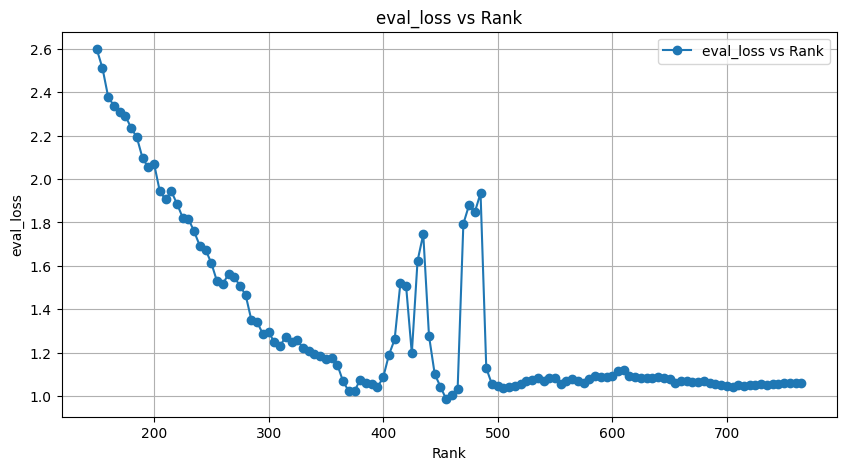

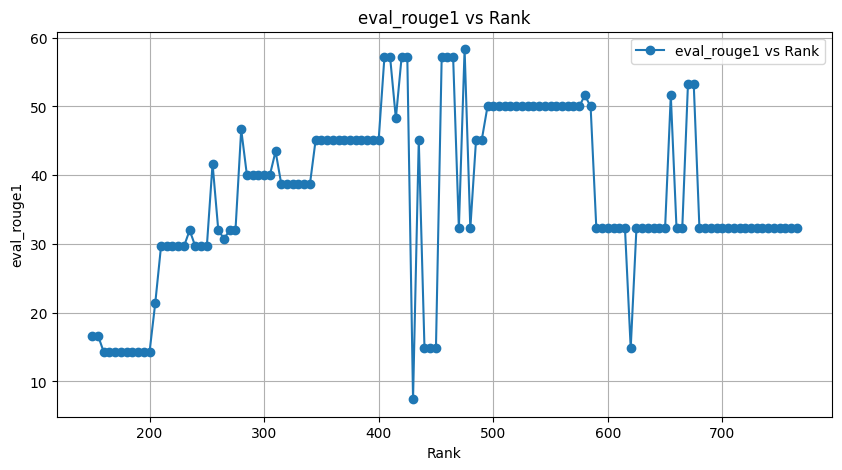

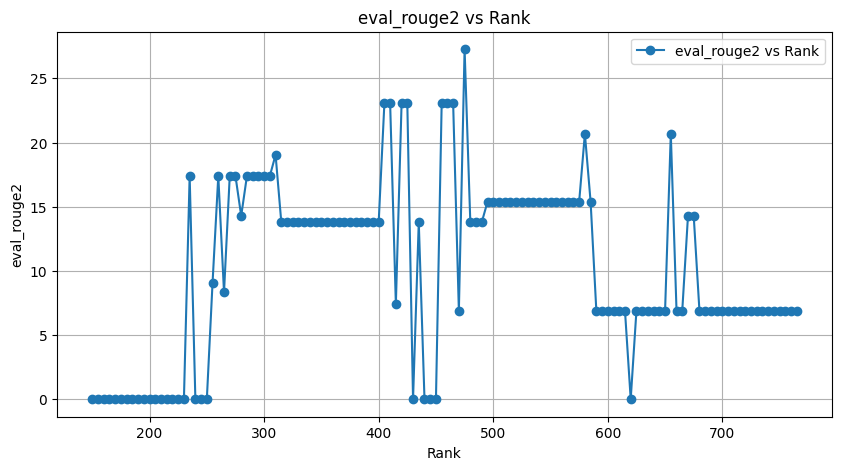

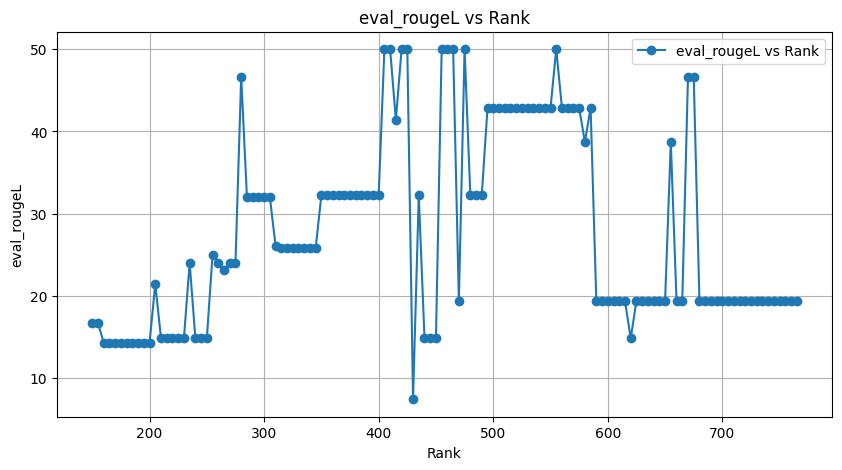

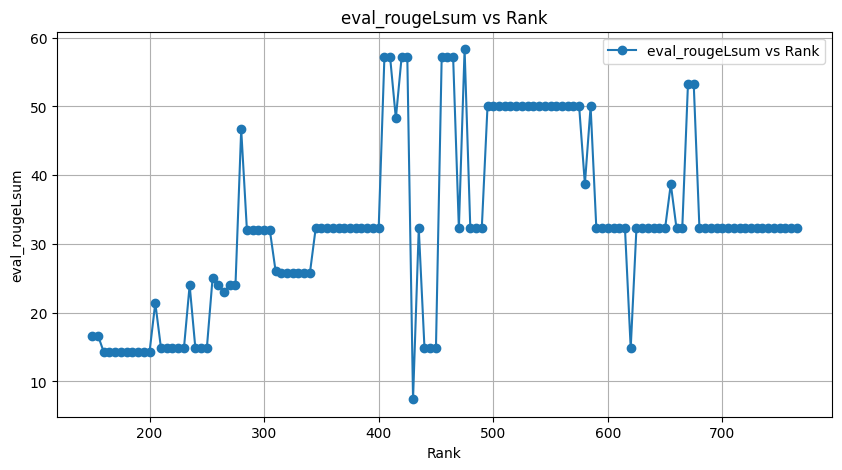

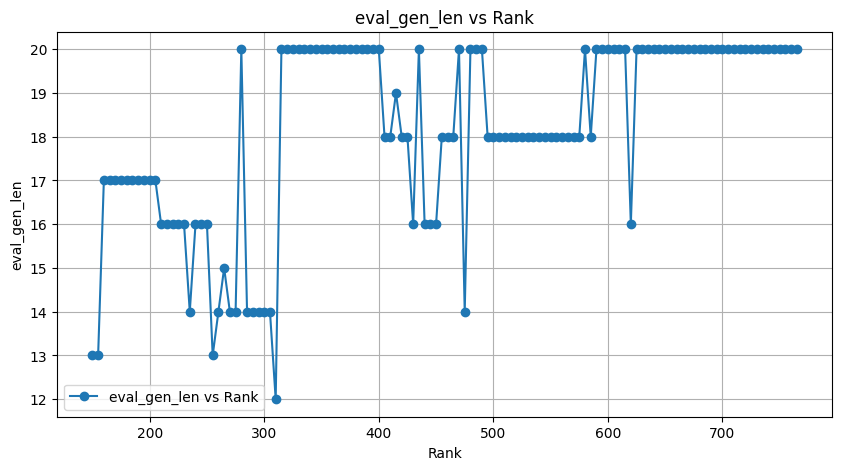

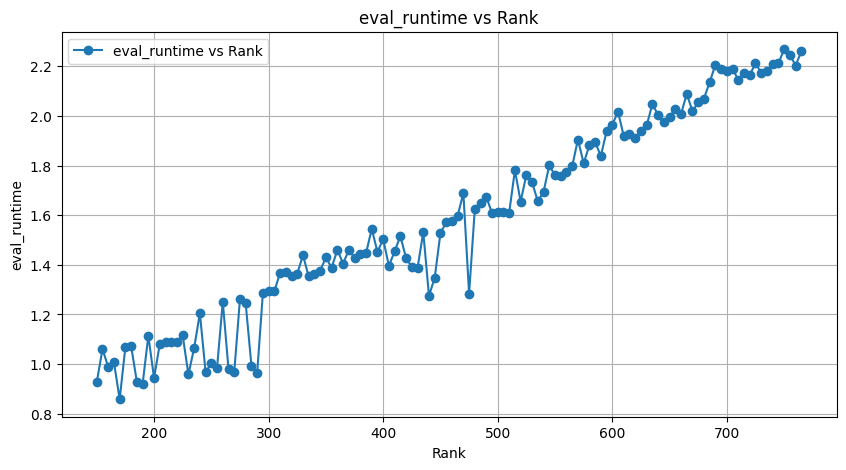

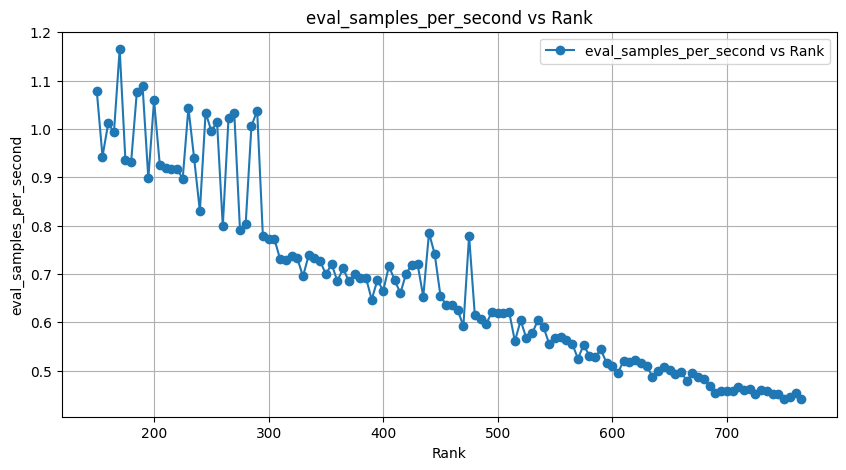

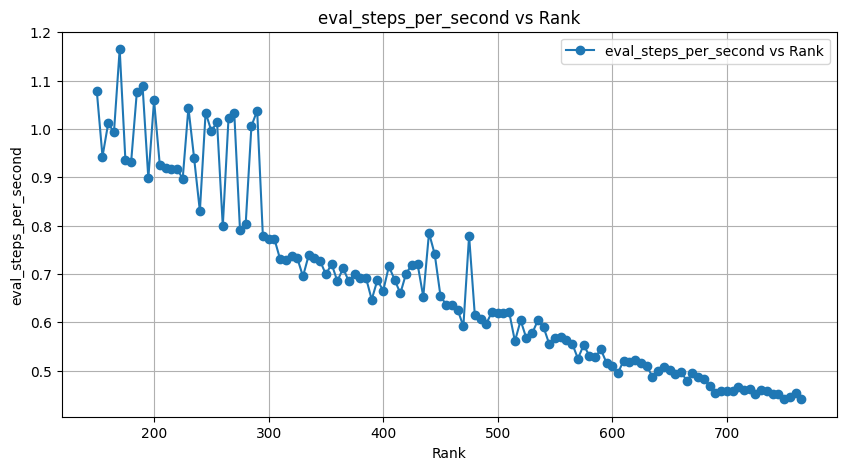

In [ ]:
import matplotlib.pyplot as plt

ranks = list(range(765, 150 - 1, -5))

# Plot each metric in a separate figure
for key in metrics_keys:
    plt.figure(figsize=(10, 5))
    plt.plot(ranks, metrics[key], marker='o', linestyle='-', label=f'{key} vs Rank')
    plt.title(f'{key} vs Rank')
    plt.xlabel('Rank')
    plt.ylabel(key)
    plt.grid(True)
    plt.legend()
    plt.show()


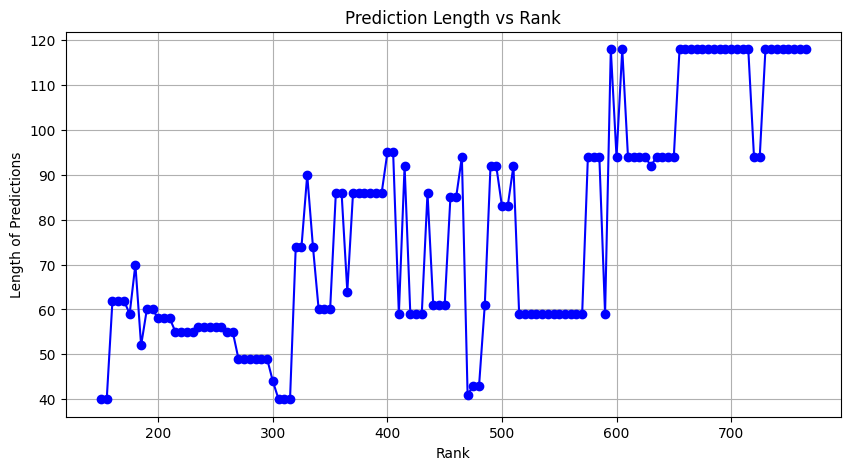

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'predictions' is a list of strings where each string is a prediction
# 'ranks' list as defined earlier
prediction_lengths = [len(pred) for pred in predictions]

plt.figure(figsize=(10, 5))
plt.plot(ranks, prediction_lengths, marker='o', linestyle='-', color='blue')
plt.title('Prediction Length vs Rank')
plt.xlabel('Rank')
plt.ylabel('Length of Predictions')
plt.grid(True)
plt.show()


In [ ]:
for rank, pred in zip(ranks, predictions):
    print(f'Rank {rank}: {pred}\n')

Rank 765: Hannah is looking for Betty's number. Amanda can't find it. Larry called her last time they were at the park together.

Rank 760: Hannah is looking for Betty's number. Amanda can't find it. Larry called her last time they were at the park together.

Rank 755: Hannah is looking for Betty's number. Amanda can't find it. Larry called her last time they were at the park together.

Rank 750: Hannah is looking for Betty's number. Amanda can't find it. Larry called her last time they were at the park together.

Rank 745: Hannah is looking for Betty's number. Amanda can't find it. Larry called her last time they were at the park together.

Rank 740: Hannah is looking for Betty's number. Amanda can't find it. Larry called her last time they were at the park together.

Rank 735: Hannah is looking for Betty's number. Amanda can't find it. Larry called her last time they were at the park together.

Rank 730: Hannah is looking for Betty's number. Amanda can't find it. Larry called her las

## Test on whole dataset (every 50 or 100 rank)


In [ ]:
# Initialize storage for metrics and predictions
base_metrics_keys = ['eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum', 'eval_gen_len', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second']
base_metrics = {key: [] for key in base_metrics_keys}
base_predictions = []

base_model = copy.deepcopy(model).to('cpu')

# Move the model to GPU if available for evaluation
if torch.cuda.is_available():
    base_model.to('cuda')
"""
Evaluate baseline BART-base and save metrics
"""
# Define a trainer for evaluation
trainer = Seq2SeqTrainer(
    model=base_model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Perform evaluation
eval_results = trainer.evaluate()
print(eval_results)

# Store metrics for the new experiment
for key in base_metrics_keys:
  if key in eval_results:
      base_metrics[key].append(eval_results[key])
  else:
      base_metrics[key].append(None)  # Append None if the key doesn't exist in results

{'eval_loss': 1.5811903476715088, 'eval_rouge1': 47.5775, 'eval_rouge2': 24.1465, 'eval_rougeL': 40.0576, 'eval_rougeLsum': 43.2979, 'eval_gen_len': 18.2613, 'eval_runtime': 69.6786, 'eval_samples_per_second': 11.754, 'eval_steps_per_second': 2.942}


In [ ]:
# Initialize storage for metrics and predictions for the new experiment
new_metrics_keys = ['eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum', 'eval_gen_len', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second']
new_metrics = {key: [] for key in new_metrics_keys}
new_predictions = []

"""
Evaluate compressed BART and save metrics
"""

# Define the range of ranks for the new experiment
start_rank = 765
end_rank = 165
step_size = 50  # Step size is 50 for the new experiment

# Before starting the loop, ensure the model is on CPU to free up GPU memory
model.to('cpu')
torch.cuda.empty_cache()  # Clear any residual GPU memory

for rank in range(start_rank, end_rank - 1, -step_size):
    gc.collect()  # Garbage collect Python objects
    torch.cuda.empty_cache()  # Clear CUDA cache

    # Perform the copy and transformation on CPU
    compressed_model = copy.deepcopy(model).to('cpu')
    config = LowRankConfig(rank=rank, target_modules=["out_proj", "q_proj", "v_proj", "k_proj"])
    loRA_Transform(compressed_model, config)

    # Move the model to GPU if available for evaluation
    if torch.cuda.is_available():
        compressed_model.to('cuda')

     # Define a trainer for evaluation
    trainer = Seq2SeqTrainer(
        model=compressed_model,
        args=args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Perform evaluation
    eval_results = trainer.evaluate()

    # Store metrics for the new experiment
    for key in new_metrics_keys:
        if key in eval_results:
            new_metrics[key].append(eval_results[key])
        else:
            new_metrics[key].append(None)  # Append None if the key doesn't exist in results


In [ ]:
import matplotlib.pyplot as plt

ranks = list(range(765, 165 - 1, -50))

# Plot each metric in a separate figure
for key in new_metrics_keys:
    plt.figure(figsize=(10, 5))

    # Check if baseline data is available and add it as a single point
    if key in base_metrics and base_metrics[key]:
        # Assuming there's only one entry in base_metrics[key], you can use base_metrics[key][0]
        plt.scatter(768, base_metrics[key], color='red', label='Baseline BART')

    # Plot compressed data
    plt.plot(ranks, new_metrics[key], marker='o', linestyle='-', label='Compressed BART')
    plt.title(f'{key} vs Rank')
    plt.xlabel('Rank')
    plt.ylabel(key)
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
ranks = [768] + list(range(765, 165 - 1, -50))
print(ranks)

# BART-Large

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model_checkpoint = "facebook/bart-large"
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

#### Preprocessing the Data

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
max_input_length = 512
max_target_length = 128

def preprocess_function(examples):
    inputs = [doc for doc in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

#### Fine-tuning the model (BART-Large)


In [ ]:
batch_size = 4
args = Seq2SeqTrainingArguments(
    "test-dialogue-summarization",
    evaluation_strategy = "epoch",
    logging_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=6,
    predict_with_generate=True,
    fp16=True
)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

In [ ]:
trainer.evaluate()

#### Evaluating

In [ ]:
# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize input
formatted_query = "Summarize: " + raw_datasets["test"][0]["dialogue"]
tokenized_text = tokenizer(formatted_query, truncation=True, max_length=2048, return_tensors='pt')

# Move tokenized text to the same device as the model
tokenized_text = tokenized_text.to(device)

# Generate predictions
generated_ids = model.generate(
    **tokenized_text,
    max_new_tokens=150,
    num_beams=4,
    no_repeat_ngram_size=2,
    early_stopping=True
)
predictions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [ ]:
predictions

In [ ]:
# Initialize storage for metrics and predictions
large_metrics_keys = ['eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum', 'eval_gen_len', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second']
large_metrics = {key: [] for key in large_metrics_keys}
large_predictions = []

"""
Evaluate baseline BART-large and save metrics
"""
# Perform evaluation
large_eval_results = trainer.evaluate()
print(large_eval_results)

# Store metrics for the new experiment
for key in large_metrics_keys:
  if key in large_eval_results:
      large_metrics[key].append(large_eval_results[key])
  else:
      large_metrics[key].append(None)  # Append None if the key doesn't exist in results

In [ ]:
# Initialize storage for metrics and predictions for the new experiment
large_compressed_metrics_keys = ['eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum', 'eval_gen_len', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second']
large_compressed_metrics = {key: [] for key in new_metrics_keys}
large_compressed_predictions = []

"""
Evaluate compressed BART and save metrics
"""

# Define the range of ranks for the new experiment
start_rank = 1005
end_rank = 165
step_size = 50  # Step size is 50 for the new experiment

# Before starting the loop, ensure the model is on CPU to free up GPU memory
model.to('cpu')
torch.cuda.empty_cache()  # Clear any residual GPU memory

for rank in range(start_rank, end_rank - 1, -step_size):
    gc.collect()  # Garbage collect Python objects
    torch.cuda.empty_cache()  # Clear CUDA cache

    # Perform the copy and transformation on CPU
    compressed_model = copy.deepcopy(model).to('cpu')
    config = LowRankConfig(rank=rank, target_modules=["out_proj", "q_proj", "v_proj", "k_proj"])
    loRA_Transform(compressed_model, config)

    # Move the model to GPU if available for evaluation
    if torch.cuda.is_available():
        compressed_model.to('cuda')

     # Define a trainer for evaluation
    trainer = Seq2SeqTrainer(
        model=compressed_model,
        args=args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Perform evaluation
    large_compressed_eval_results = trainer.evaluate()

    # Store metrics for the new experiment
    for key in large_compressed_metrics_keys:
        if key in large_compressed_eval_results:
            large_compressed_metrics[key].append(large_compressed_eval_results[key])
        else:
            large_compressed_metrics[key].append(None)  # Append None if the key doesn't exist in results

In [ ]:
import matplotlib.pyplot as plt

ranks = list(range(1005, 165 - 1, -50))

# Plot each metric in a separate figure
for key in large_compressed_metrics_keys:
    plt.figure(figsize=(10, 5))

    # Check if baseline data is available and add it as a single point
    if key in large_metrics and large_metrics[key]:
        plt.scatter(1024, large_metrics[key], color='red', label='Baseline BART-large')

    # Plot compressed data
    plt.plot(ranks, large_compressed_metrics[key], marker='o', linestyle='-', label='Compressed BART-large')
    plt.title(f'{key} vs Rank')
    plt.xlabel('Rank')
    plt.ylabel(key)
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming new_metrics_keys and large_compressed_metrics_keys are the same, we'll use one set of keys
metrics_keys = new_metrics_keys  # Or adjust according to your data

# Define the ranks for both models
ranks_new = list(range(765, 165 - 1, -50))
ranks_large = list(range(1005, 165 - 1, -50))

# Plot each metric in a single figure for both models
for key in metrics_keys:
    plt.figure(figsize=(10, 5))

    # Check and plot baseline data for BART (new model)
    if key in base_metrics and base_metrics[key]:
        plt.scatter(768, base_metrics[key][0], marker = 'x', color='blue', label='Baseline BART')

    # Check and plot baseline data for BART-large
    if key in large_metrics and large_metrics[key]:
        plt.scatter(1024, large_metrics[key][0], marker = 'x', color='red', label='Baseline BART-large')

    # Plot compressed data for both models
    if key in new_metrics:
        plt.plot(ranks_new, new_metrics[key], marker='o', linestyle='-', color='blue', label='Compressed BART')
    if key in large_compressed_metrics:
        plt.plot(ranks_large, large_compressed_metrics[key], marker='o', linestyle='-', color='red', label='Compressed BART-large')

    plt.title(f'{key} vs Rank')
    plt.xlabel('Rank')
    plt.ylabel(key)
    plt.grid(True)
    plt.legend()
    plt.show()


#### Summaries

In [ ]:
import gc
import torch
import copy

# Define the range of ranks for the new experiment
start_rank = 1005
end_rank = 165
step_size = 20  # Adjust the step size as necessary

# Ensure the model is on CPU to free up GPU memory
model.to('cpu')

for rank in range(start_rank, end_rank - 1, -step_size):
    torch.cuda.empty_cache()  # Clear CUDA cache if model was previously on GPU

    # Perform the copy and transformation on CPU
    compressed_model = copy.deepcopy(model)
    config = LowRankConfig(rank=rank, target_modules=["out_proj", "q_proj", "v_proj", "k_proj"])
    loRA_Transform(compressed_model, config)

    # Ensure the tokenized text is on CPU as well
    tokenized_text = tokenized_text.to('cpu')  # Move tokenized text to CPU

    # Generate predictions on the CPU
    generated_ids = compressed_model.generate(
        **tokenized_text,
        max_new_tokens=150,
        num_beams=4,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    prediction = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    large_compressed_predictions.append(prediction)

gc.collect()  # Collect garbage to free memory if necessary


In [ ]:
large_compressed_predictions

# Print Model BART-Base
Getting to know the model so we can inspect it

In [ ]:
from transformers import AutoModelForSeq2SeqLM
model_checkpoint = "facebook/bart-base"
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
model

In [ ]:
# print rank of weight matrix
torch.linalg.matrix_rank(model.encoder.layers[0].self_attn.k_proj.weight)